In [1]:
import cv2 as cv
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import axes3d    

import numpy as np
import cvlib
import plot
import os

plt.style.use('dark_background') 

%matplotlib inline

PATH = 'placas/'
archivos = os.listdir(PATH)

In [6]:
# Primera entrega
# Lorena Perez 20200396

In [2]:
def select_placa(imagen):

    im = cv.imread(imagen, cv.IMREAD_COLOR)
    # Imagen en formato RGB
    im = cv.cvtColor(im, cv.COLOR_BGR2RGB)

    print(f"Procesando imagen:")
    # Analisis de canales
    b_ch, g_ch, r_ch = cv.split(im)
    b_h = cv.calcHist([b_ch], [0], None, [256], [0, 256])
    g_h = cv.calcHist([g_ch], [0], None, [256], [0, 256])
    r_h = cv.calcHist([r_ch], [0], None, [256], [0, 256])

    # Calculando la varianza
    b_var = np.var(b_h)
    g_var = np.var(g_h)
    r_var = np.var(r_h)

    # Determinando el de menor varianza
    if b_var < g_var and b_var < r_var:
        select_ch = b_ch
    elif g_var < b_var and g_var < r_var:
        select_ch = g_ch
    else:
        select_ch = r_ch

    # Asignando canal
    imgray = select_ch

    # Procesamiento para la imagen
    imgray = plot.imgnorm(imgray)
    _, imgray = cv.threshold(imgray, 210, 255,cv.THRESH_TRUNC)
    _, imgray = cv.threshold(imgray, 60, 255,cv.THRESH_TOZERO)
    imgray = cv.GaussianBlur(imgray, (5,5), 10)
    imgray = plot.imgnorm(imgray)
        
    img = im.copy()
    # Margenes que funcionan por prueba y error: 33, 2 -- 17,2
    # Margen ultima prueba 17,1
    # 31, 5
    thresh = cv.adaptiveThreshold(imgray, 255,cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV,17,1)
    contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)
    print("Numero de objetos detectados:", len(contours))

    def extent(cnt):
        area = cv.contourArea(cnt)
        x,y,w,h = cv.boundingRect(cnt)
        rect_area = w*h
        extent = float(area)/rect_area
        return extent
    
    m, n = 0, 0
    for i, cnt in enumerate(contours):
        ext = extent(cnt)
        ext = round(ext, 2)
        x,y,w,h = cv.boundingRect(cnt)
        img = cv.drawContours(img,[cnt],0,(0,255,0),2)
        img = cv.rectangle(img,(x,y),(x+w,y+h),(0,255,255),2)
        #cv.putText(img, f'Extent={ext}', (x, y), cv.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
        if (ext > m):
            n = i 
            m = ext

    print("--------------------------------")
    print(f"Objeto # {n+1}, con mayor extend: {m}")

    x, y, w, h = cv.boundingRect(contours[n])
    placa = im[y:y+h, x:x+w]
    img_ = im.copy()
    cv.rectangle(img_, (x, y), (x + w, y + h), (0, 255, 0), 4)
    print(placa.shape)
    # Visualizar imagen
    # plot.imgcmp(imgray, thresh)
    # plot.imgcmp(thresh, placa)

    return placa

In [3]:
def detect_component(result_placa):
    h, w, _ = result_placa.shape
    c_w = int(0.04 * w)
    c_h = int(0.11 * h)
    x1 = c_w
    y1 = c_h
    x2 = w - c_w
    y2 = h - c_h
    img = result_placa[y1:y2, x1:x2]

    imgray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    imgray = cv.GaussianBlur(imgray, (7,7), 1)
    imgray = plot.imgnorm(imgray)
    hist = cv.calcHist([imgray], [0], None, [256], [0, 256])
    
    brillo = sum(hist[100:])
    threshold = 0.5
    print(f"Brillo total sobre 100: {brillo}, total histograma: {sum(hist)}")
    print(f"Margen para la binarizacion 0.5: {brillo / sum(hist)}")
    if brillo / sum(hist) > threshold:
        # img_bin = cv.threshold(imgray, 140, 255, cv.THRESH_BINARY_INV|cv.THRESH_OTSU)[1] 
        img_bin = cv.adaptiveThreshold(imgray, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV, 33, 5)
    else:
        # img_bin = cv.threshold(imgray, 127, 255, cv.THRESH_BINARY)[1] 
        img_bin = cv.adaptiveThreshold(imgray, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 23, -2)

    kernel = np.ones((3, 3), np.uint8)
    img_bin = cv.erode(img_bin, kernel, iterations=1)
    # img_bin = cv.adaptiveThreshold(imgray, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV, 17, 2)
    components = cv.connectedComponentsWithStats(img_bin, connectivity=4)

    result_image = img.copy()
    contours_area = []
    w_med = []
    h_med = []

    for i in range(1, components[0]):
        x, y, w, h, area = components[2][i]
        contours_area.append(area)
    
    indice_max = np.argmax(contours_area)
    valor_maximo = contours_area[indice_max] * 0.10

    for i in range(1, components[0]):
        x, y, w, h, area = components[2][i]
        if area >= valor_maximo:
            if h > w:
                w_med.append(w)
                h_med.append(h)

    if len(h_med) != 0:
        valor_max_h = (sum(h_med)/len(h_med)) * 1.40
        valor_min_h = (sum(h_med)/len(h_med)) * 0.75
    else:
        valor_max_h = imgray.shape[0]
        valor_min_h = 0

    print(f"Margen del threshold: {valor_maximo}")
    print(f"Altura max: {valor_max_h} y altura min: {valor_min_h}")

    for i in range(1, components[0]):
        x, y, w, h, area = components[2][i]
        if area >= valor_maximo:
            if h > w:
                if h > valor_min_h and h < valor_max_h:
                    cv.rectangle(result_image, (x, y), (x + w, y + h), (0, 0, 255), 2)  # Dibujar rectángulo rojo

    # plot.imgcmp(img_bin, imgray)
    plot.imgcmp(result_placa, result_image)

# detect_component(result_placa)

Archivo:  images10.jpg
Procesando imagen:
Numero de objetos detectados: 811
--------------------------------
Objeto # 472, con mayor extend: 0.96
(148, 556, 3)
Brillo total sobre 100: [46681.], total histograma: [59392.]
Margen para la binarizacion 0.5: [0.7859813]
Margen del threshold: 159.3
Altura max: 96.94999999999999 y altura min: 51.9375


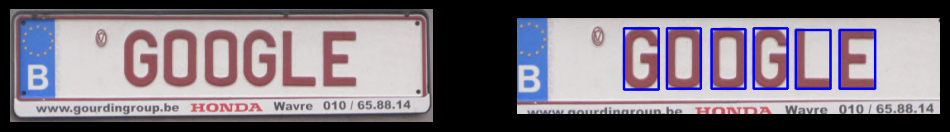

Archivo:  images100.jpg
Procesando imagen:
Numero de objetos detectados: 2035
--------------------------------
Objeto # 963, con mayor extend: 0.98
(105, 521, 3)
Brillo total sobre 100: [31607.], total histograma: [39923.]
Margen para la binarizacion 0.5: [0.791699]
Margen del threshold: 149.8
Altura max: 103.6 y altura min: 55.5


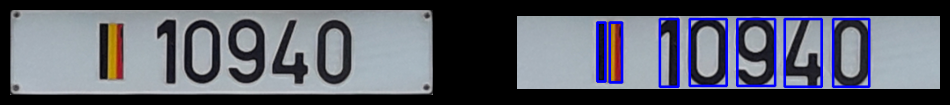

Archivo:  images101.jpg
Procesando imagen:
Numero de objetos detectados: 990
--------------------------------
Objeto # 446, con mayor extend: 0.97
(109, 521, 3)
Brillo total sobre 100: [33202.], total histograma: [41847.]
Margen para la binarizacion 0.5: [0.7934141]
Margen del threshold: 159.8
Altura max: 105.4 y altura min: 56.46428571428572


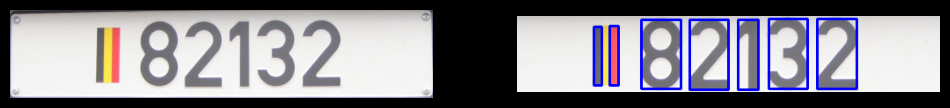

Archivo:  images102.jpg
Procesando imagen:
Numero de objetos detectados: 493
--------------------------------
Objeto # 132, con mayor extend: 0.95
(149, 480, 3)
Brillo total sobre 100: [38275.], total histograma: [51714.]
Margen para la binarizacion 0.5: [0.7401284]
Margen del threshold: 226.9
Altura max: 135.2 y altura min: 72.42857142857143


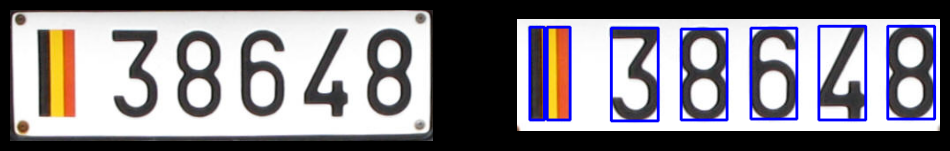

Archivo:  images103.jpg
Procesando imagen:
Numero de objetos detectados: 586
--------------------------------
Objeto # 361, con mayor extend: 0.97
(155, 499, 3)
Brillo total sobre 100: [32874.], total histograma: [55781.]
Margen para la binarizacion 0.5: [0.58934045]
Margen del threshold: 344.5
Altura max: 153.29999999999998 y altura min: 82.125


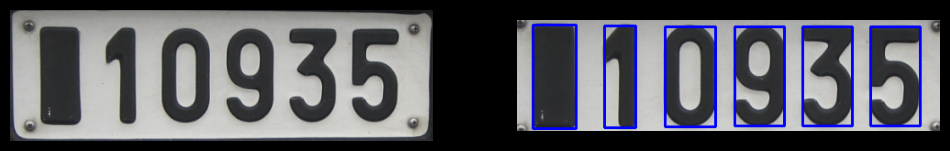

Archivo:  images104.jpg
Procesando imagen:
Numero de objetos detectados: 491
--------------------------------
Objeto # 140, con mayor extend: 0.87
(161, 508, 3)
Brillo total sobre 100: [37525.], total histograma: [59436.]
Margen para la binarizacion 0.5: [0.63135135]
Margen del threshold: 344.90000000000003
Altura max: 159.25 y altura min: 85.3125


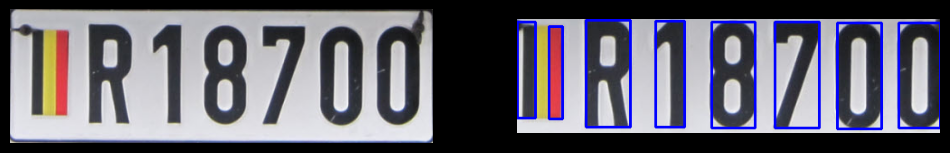

Archivo:  images105.jpg
Procesando imagen:
Numero de objetos detectados: 340
--------------------------------
Objeto # 84, con mayor extend: 0.83
(49, 133, 3)
Brillo total sobre 100: [2618.], total histograma: [4797.]
Margen para la binarizacion 0.5: [0.5457578]
Margen del threshold: 28.1
Altura max: 35.93333333333333 y altura min: 19.25


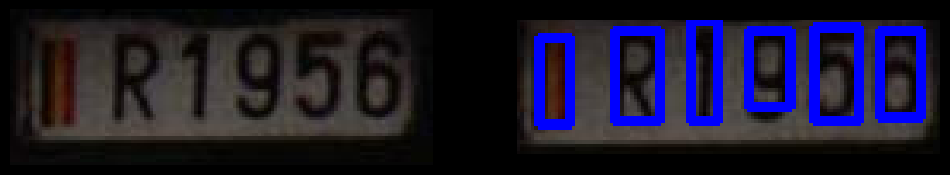

Archivo:  images106.jpg
Procesando imagen:
Numero de objetos detectados: 298
--------------------------------
Objeto # 14, con mayor extend: 0.95
(299, 248, 3)
Brillo total sobre 100: [31716.], total histograma: [54050.]
Margen para la binarizacion 0.5: [0.58679]
Margen del threshold: 243.0
Altura max: 140.46666666666664 y altura min: 75.25


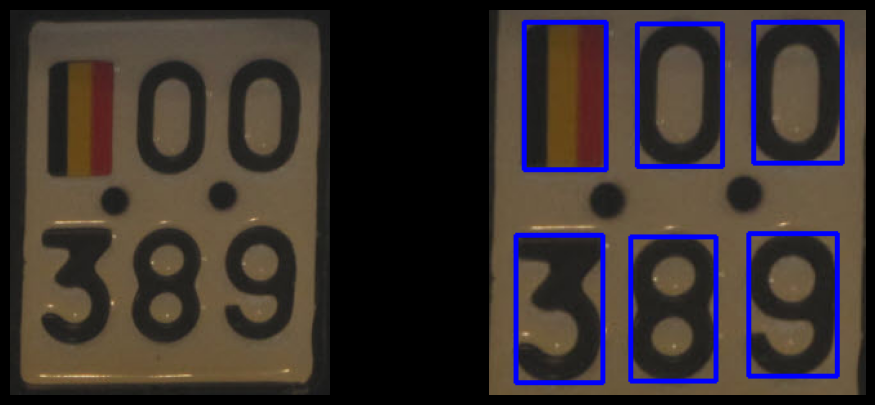

Archivo:  images107.jpg
Procesando imagen:
Numero de objetos detectados: 414
--------------------------------
Objeto # 272, con mayor extend: 0.94
(124, 101, 3)
Brillo total sobre 100: [6910.], total histograma: [9114.]
Margen para la binarizacion 0.5: [0.75817424]
Margen del threshold: 35.6
Altura max: 51.4 y altura min: 27.535714285714285


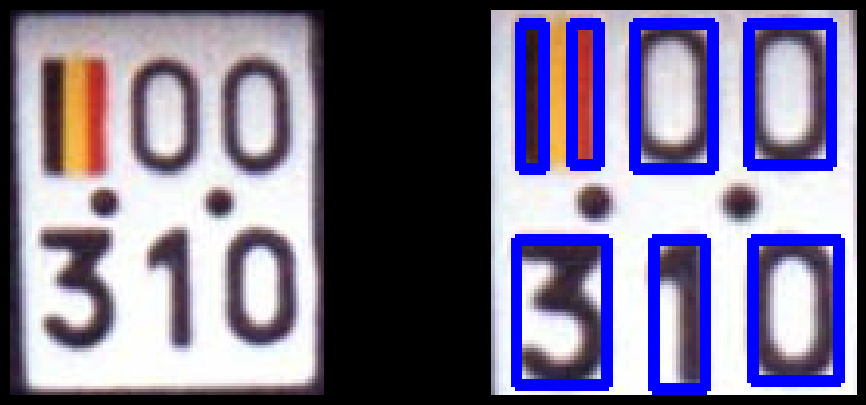

Archivo:  images108.jpg
Procesando imagen:
Numero de objetos detectados: 817
--------------------------------
Objeto # 580, con mayor extend: 0.97
(117, 558, 3)
Brillo total sobre 100: [13733.], total histograma: [47802.]
Margen para la binarizacion 0.5: [0.28728923]
Margen del threshold: 167.60000000000002
Altura max: 102.0 y altura min: 54.642857142857146


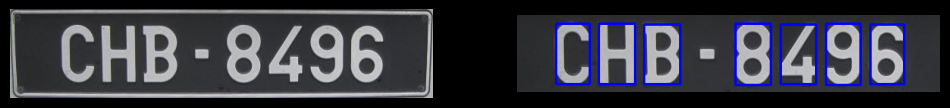

Archivo:  images109.jpg
Procesando imagen:
Numero de objetos detectados: 319
--------------------------------
Objeto # 156, con mayor extend: 0.96
(128, 507, 3)
Brillo total sobre 100: [18359.], total histograma: [46700.]
Margen para la binarizacion 0.5: [0.39312634]
Margen del threshold: 248.20000000000002
Altura max: 124.79999999999998 y altura min: 66.85714285714286


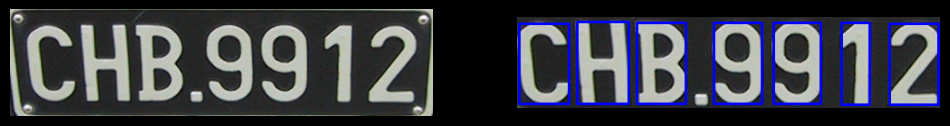

Archivo:  images11.jpg
Procesando imagen:
Numero de objetos detectados: 475
--------------------------------
Objeto # 248, con mayor extend: 0.97
(115, 550, 3)
Brillo total sobre 100: [37170.], total histograma: [46046.]
Margen para la binarizacion 0.5: [0.80723625]
Margen del threshold: 182.4
Altura max: 106.6 y altura min: 57.107142857142854


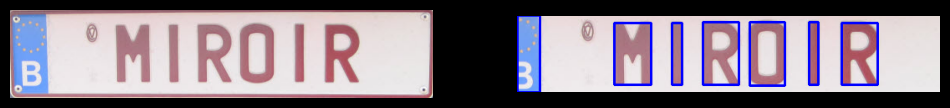

Archivo:  images110.jpg
Procesando imagen:
Numero de objetos detectados: 655
--------------------------------
Objeto # 614, con mayor extend: 0.96
(158, 478, 3)
Brillo total sobre 100: [18722.], total histograma: [54560.]
Margen para la binarizacion 0.5: [0.34314516]
Margen del threshold: 251.0
Altura max: 132.8 y altura min: 71.14285714285714


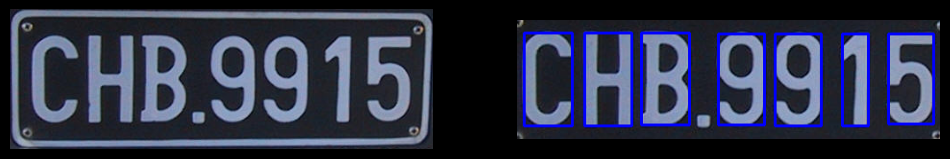

Archivo:  images111.jpg
Procesando imagen:
Numero de objetos detectados: 213
--------------------------------
Objeto # 66, con mayor extend: 0.89
(99, 497, 3)
Brillo total sobre 100: [29555.], total histograma: [36261.]
Margen para la binarizacion 0.5: [0.815063]
Margen del threshold: 125.7
Altura max: 90.53333333333333 y altura min: 48.5


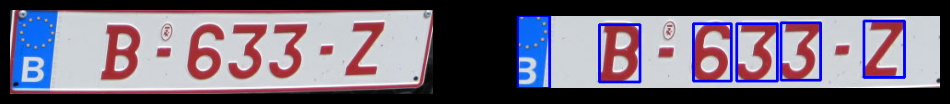

Archivo:  images112.jpg
Procesando imagen:
Numero de objetos detectados: 606
--------------------------------
Objeto # 433, con mayor extend: 0.96
(108, 537, 3)
Brillo total sobre 100: [34382.], total histograma: [42570.]
Margen para la binarizacion 0.5: [0.80765796]
Margen del threshold: 163.9
Altura max: 104.3 y altura min: 55.875


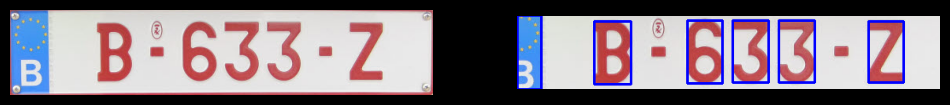

Archivo:  images113.jpg
Procesando imagen:
Numero de objetos detectados: 467
--------------------------------
Objeto # 388, con mayor extend: 0.93
(94, 491, 3)
Brillo total sobre 100: [13029.], total histograma: [33522.]
Margen para la binarizacion 0.5: [0.38867012]
Margen del threshold: 189.5
Altura max: 96.03999999999999 y altura min: 51.449999999999996


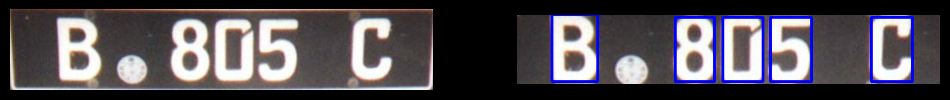

Archivo:  images114.jpg
Procesando imagen:
Numero de objetos detectados: 383
--------------------------------
Objeto # 239, con mayor extend: 0.83
(59, 195, 3)
Brillo total sobre 100: [2737.], total histograma: [8507.]
Margen para la binarizacion 0.5: [0.32173505]
Margen del threshold: 18.6
Altura max: 25.51111111111111 y altura min: 13.666666666666666


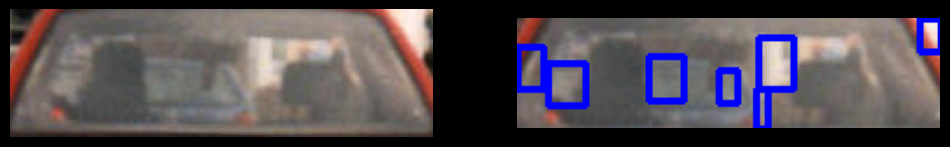

Archivo:  images115.jpg
Procesando imagen:
Numero de objetos detectados: 657
--------------------------------
Objeto # 219, con mayor extend: 0.89
(120, 559, 3)
Brillo total sobre 100: [14622.], total histograma: [48410.]
Margen para la binarizacion 0.5: [0.30204502]
Margen del threshold: 162.10000000000002
Altura max: 88.19999999999999 y altura min: 47.25


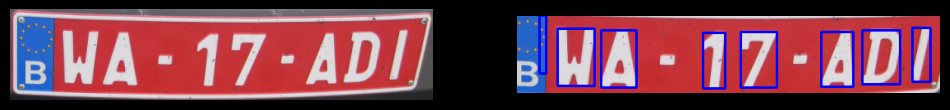

Archivo:  images116.jpg
Procesando imagen:
Numero de objetos detectados: 846
--------------------------------
Objeto # 164, con mayor extend: 0.95
(121, 548, 3)
Brillo total sobre 100: [17113.], total histograma: [48070.]
Margen para la binarizacion 0.5: [0.35600168]
Margen del threshold: 156.3
Altura max: 96.44444444444443 y altura min: 51.666666666666664


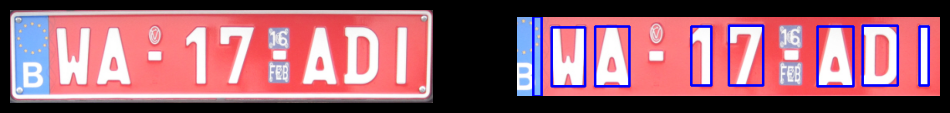

Archivo:  images117.jpg
Procesando imagen:
Numero de objetos detectados: 845
--------------------------------
Objeto # 511, con mayor extend: 0.94
(108, 506, 3)
Brillo total sobre 100: [15552.], total histograma: [40076.]
Margen para la binarizacion 0.5: [0.3880627]
Margen del threshold: 174.8
Altura max: 96.28888888888888 y altura min: 51.58333333333333


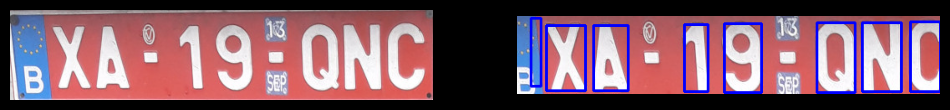

In [4]:
archivos = os.listdir(PATH)
c = 0
for archivo in archivos:
    if archivo.endswith('.jpg'):
        print("Archivo: ", archivo)
        imagen = os.path.join(PATH, archivo)
        result_placa = select_placa(imagen)
        c = c+1
        detect_component(result_placa)
        # break
        if c == 20:
            break

Procesando imagen:
Numero de objetos detectados: 260
--------------------------------
Objeto # 132, con mayor extend: 0.95
(280, 480, 3)
Brillo total sobre 100: [80119.], total histograma: [97240.]
Margen para la binarizacion 0.5: [0.8239305]
Margen del threshold: 247.60000000000002
Altura max: 125.3 y altura min: 67.125


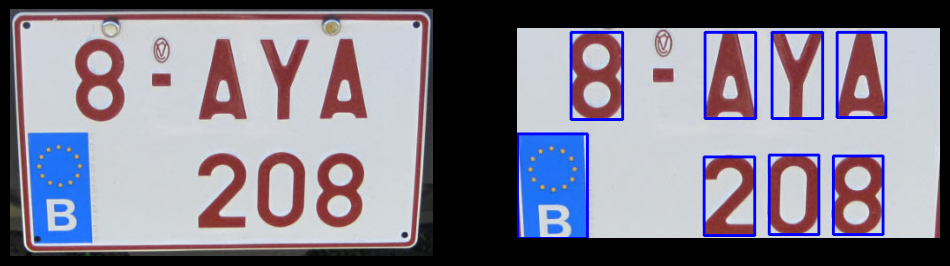

In [7]:
# Prueba
imagen = 'placas/images166.jpg' 
result_placa = select_placa(imagen)
detect_component(result_placa)